In [459]:
BOOK = "emotion"

In [460]:
from glob import glob
import json, datetime, time, os, random

%matplotlib inline
from matplotlib import pyplot as plt

import scipy
from tslearn import metrics as tsm

from scipy import ndimage, signal
import scipy.spatial.distance as distance
from scipy.spatial.distance import euclidean,pdist, squareform, cdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import numpy as np
from numpy.lib.stride_tricks import as_strided
np.set_printoptions(precision=3, suppress=True)  # suppress scientific float notation

import pandas as pd
import os, json, platform
import pylab as pl
from pprint import pprint

# CLUSTERING CODE

In [461]:
def get_file(folder, prefix):
    user = os.path.basename(folder)
    files = glob(folder + "/"+prefix+"*.json")
    if len(files) == 0:
        print("File not found", prefix, 'in', folder)
        return None
    else: 
        with open(files[0], 'r') as f: 
            contents = json.load(f)
            return contents, files[0]
        
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('Sample index or (cluster size)')
        plt.ylabel('Distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata


    
    
# DISTANCE METRICS
# Similarity Distance
def EuclideanDistance(t1, t2):
    return np.sqrt(np.sum((t1-t2)**2))

# Dynamic Time Warping Distance
def DTWDistance(s1, s2):
    # Initialize distance matrix (nxn), pad filling with inf  
    DTW= {}
    n1 = range(len(s1))
    n2 = range(len(s2))
    for i in n1:
        DTW[(i, -1)] = float('inf')
    for i in n2:
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0
    
    # Compute the distances (O(nm) time)
    for i in n1:
        for j in n2:
            dist = (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)], DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])
def DTWDistanceD(t1, t2):
    arr = []
    for i in range(0, t1.shape[0]):
        arr.append(DTWDistance(t1[i], t2[i]))
    return sum(arr)

def DTWDistance2D(t1, t2):
    t1 = t1.reshape(WORD_SHAPE)
    t2 = t2.reshape(WORD_SHAPE)
    arr = []
    for i in range(0, t1.shape[0]):
        arr.append(DTWDistance(t1[i], t2[i]))
    return sum(arr)

def sample_sss(A, n):
    return A[np.random.choice(A.shape[0], n, replace=False), :]

def dtw2(a, b):
    a = a.reshape(WORD_SHAPE)
    b = b.reshape(WORD_SHAPE)
    return tsm.dtw(a, b)

# LOAD DATA INTO MEMORY

`
meta = {
    "L": L,
    "word_shape": word_shape,
    "description": "Accelerometer data for 2 users.",
    "users": users, 
    "features": features, 
    "subsequences": sss.tolist()
}
`

In [462]:
DATASET_ROOT = "irb/datasets/codebooks"
contents, f = get_file(DATASET_ROOT, BOOK + "_codebook")

WORD_SHAPE = tuple(contents["word_shape"])
sss = np.array(contents["subsequences"])
USERS = np.array(contents["users"])
feat = np.array(contents["features"])
BOUNDS = np.array(contents["bounds"])
WINDOW_SIZE = contents["window_size"]

print(os.path.basename(f), ",".join(feat), USERS)
print("(n=%s, %s)" % (sss.shape))
print("word_shape --> features=%s, L=%s)" % (WORD_SHAPE))

emotion_codebook.json phasic,hr [111 112 113 211 212 214 411 412 413 414 512 613 614 711 713 811 813]
(n=9533, 38)
word_shape --> features=2, L=19)


# GREEDY K-CENTER SAMPLING

In [463]:
def sample_kcenters_pdist(words, kcenters, cull_threshold=100):
    
    if len(words) <= 1: 
        return np.array(kcenters)
    
    dtw_along_axis = np.vectorize(dtw2, signature='(n),(m)->()')
    dists = dtw_along_axis(words, kcenters[-1])
    
    idx = np.argsort(dists)
    kcenters.append(words[idx[-1]])    
    dists = np.sort(dists)
    print("WORDS", words.shape[0], "CENTERS", len(kcenters))
#     print(dists)
    cull_at = np.argmax(dists>cull_threshold)
    cull_indices = idx[:cull_at]
    cull_indices = np.append(cull_indices, idx[-1])
    words = np.delete(words, cull_indices, 0)
    return np.array(sample_kcenters_pdist(words, kcenters, cull_threshold))
    

In [473]:
CULL_THRESHOLD = 0.15
SAMPLE_PROP = 1.0 # Sample X% of the subsequence dataset
SAMPLE_SIZE = int(sss.shape[0] * SAMPLE_PROP)
FIRST_CENTER = random.randint(0,SAMPLE_SIZE)
print(sss.shape, SAMPLE_SIZE)
code_sample = sample_sss(sss, SAMPLE_SIZE)
seed = code_sample[FIRST_CENTER]
code_sample = np.delete(code_sample, FIRST_CENTER, 0)

(9533, 38) 9533


In [474]:
centers = sample_kcenters_pdist(code_sample, [seed], CULL_THRESHOLD)
print(centers.shape)

WORDS 9532 CENTERS 2
WORDS 8131 CENTERS 3
WORDS 8130 CENTERS 4
WORDS 8100 CENTERS 5
WORDS 8099 CENTERS 6
WORDS 8076 CENTERS 7
WORDS 8075 CENTERS 8
WORDS 8054 CENTERS 9
WORDS 8017 CENTERS 10
WORDS 7993 CENTERS 11
WORDS 7982 CENTERS 12
WORDS 7978 CENTERS 13
WORDS 7958 CENTERS 14
WORDS 7923 CENTERS 15
WORDS 7758 CENTERS 16
WORDS 7749 CENTERS 17
WORDS 7746 CENTERS 18
WORDS 7711 CENTERS 19
WORDS 7710 CENTERS 20
WORDS 7693 CENTERS 21
WORDS 7652 CENTERS 22
WORDS 7601 CENTERS 23
WORDS 7390 CENTERS 24
WORDS 7346 CENTERS 25
WORDS 7331 CENTERS 26
WORDS 7254 CENTERS 27
WORDS 7253 CENTERS 28
WORDS 7176 CENTERS 29
WORDS 7175 CENTERS 30
WORDS 7119 CENTERS 31
WORDS 7118 CENTERS 32
WORDS 7110 CENTERS 33
WORDS 6813 CENTERS 34
WORDS 6806 CENTERS 35
WORDS 6432 CENTERS 36
WORDS 6430 CENTERS 37
WORDS 6401 CENTERS 38
WORDS 6380 CENTERS 39
WORDS 6379 CENTERS 40
WORDS 6255 CENTERS 41
WORDS 6254 CENTERS 42
WORDS 6251 CENTERS 43
WORDS 6250 CENTERS 44
WORDS 6079 CENTERS 45
WORDS 6078 CENTERS 46
WORDS 5937 CENTERS

# HIEARCHICAL CLUSTERING

In [475]:
# generate the linkage matrix
# seqs = sss # full dataset
seqs = centers # sampled dataset
Z = linkage(seqs, method='complete', metric=dtw2)

In [476]:
# set cut-off to 50
max_d = 5  # max_d as in max_distance
print(centers.shape)

(115, 38)


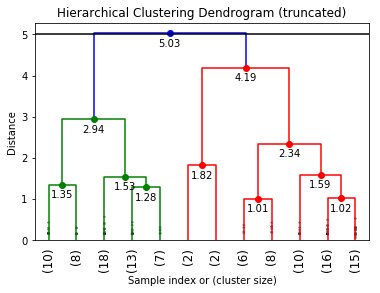

In [477]:

fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above= 0.4,  # useful in small plots so annotations don't overlap
    max_d=max_d,
)
plt.show()


# Assembling the codebook

Samples  9533
Clusters found 8


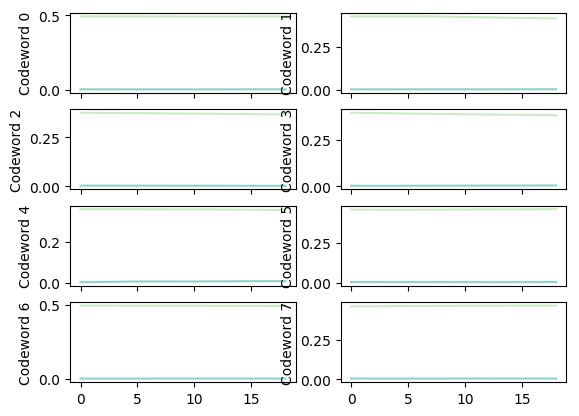

In [507]:
K = 8
centers = sss
# clusters = fcluster(Z, max_d, criterion='distance')
clusters = fcluster(Z, K, criterion='maxclust')

print("Samples ", len(centers))
n_clusters = np.max(clusters)
print("Clusters found", n_clusters)

codebook = {}
for i in range(0, len(clusters)):
    cluster_id = clusters[i]
    if not cluster_id in codebook:
        codebook[cluster_id] = []
    codebook[cluster_id].append(centers[i])

# CALCULATE THE CENTROID    
for k in codebook:
    codeset = np.array(codebook[k])
    dist = np.sum(squareform(distance.pdist(codeset, metric=dtw2)), 0)
    clustroid = np.argmin(dist)
    codebook[k] = codeset[clustroid]

codebook = codebook.values()
visualize_codebook(codebook, subplot=True)


# Applying the codebook

In [508]:
activity = sss
cb = np.array(list(codebook))
print(cb.shape)

result = []
for i, window in enumerate(activity):
    codeword = np.argmin([dtw2(codeword, window) for codeword in cb])
    result.append(codeword + 1)          

(8, 38)


In [509]:
arr = np.array(result)
sizes = []
for i in range(0, len(BOUNDS)-1):
    start = BOUNDS[i]
    end = BOUNDS[i+1]
    sizes.append(end-start)
tn = max(sizes)

results = np.full((len(BOUNDS) - 1, tn), 0)



In [510]:

for u in results:
    kernel = 20
    smooth = []
    for i in np.arange(0, u.shape[0]):
        window = u[i:(i+kernel)]
        counts = np.bincount(window)
        smooth.append(np.argmax(counts))
#     print(len(smooth), smooth)
    results[u] = np.array(smooth)
print(results)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [511]:
'''
00:00:00.000 --> 00:00:05.000
Codeword 2
'''

def format_vtt(s):
    hours, remainder = divmod(s, 3600)
    minutes, seconds = divmod(remainder, 60)
    seconds, milliseconds = divmod(seconds, 1)
    milliseconds = int(1000*milliseconds)
    return '{:02}:{:02}:{:02}.{:03}'.format(int(hours), int(minutes), int(seconds), milliseconds)

def plrgb2rgba(color):
    r,g,b,a = color
    r = int(r * 255)
    g = int(g * 255)
    b = int(b * 255)
    return "rgba(%i, %i, %i, %f)" % (r,g,b,a)
    
    
def make_vtt(u, codes, prefix):
    vtt_filename = os.path.join('irb', str(u), prefix+"_"+str(u)+".vtt")
    N = n_clusters
    cm = plt.get_cmap("Set3")
    colors = [cm(i) for i in np.linspace(0, 1, N+1)]
    
    with open(vtt_filename, 'w') as f:
        f.write("WEBVTT FILE\n")
        
        windows_past = 0
        
        for id, codeword in enumerate(codes):
            code_id, width = codes[id]
            
            start = (WINDOW_SIZE/2) * windows_past
            end = start + ((WINDOW_SIZE/2) * width)
            windows_past = windows_past + width

            start = format_vtt(start)
            end = format_vtt(end)
        
            f.write("\n%s --> %s\n"%(start, end))
            
            color = plrgb2rgba(colors[code_id])
            cue = {
                "code": str(code_id),
                "width": width,
                "color": color,
                "display": "<div style='background: %s'>%s</div>"% (color, code_id)
            }
            
            f.write(json.dumps(cue))
            f.write("\n")

#     print(u, codes.shape, WINDOW_SIZE)
    
    print("File saved!", vtt_filename)

In [521]:

def sparse_cue(r):
    r = r[np.nonzero(r)]
    sparse_result = []
    current = None
    width = 0
    for c in r:
        if current == None:
            current = c

        if current == c:
            width = width + 1
        else:
            sparse_result.append((current, width))
            current = c
            width = 1
    sparse_result.append((current, width))
    return sparse_result

sparse_results = list(map(sparse_cue, results))
print(sparse_results)
# print(results[0])
# print(results[0][np.nonzero(results[0])])


[[(2, 3), (4, 4), (3, 5), (5, 16), (3, 1), (4, 3), (2, 4), (6, 9), (8, 5), (6, 7), (8, 2), (1, 3), (7, 23), (1, 3), (8, 2), (1, 6), (7, 3), (1, 2), (7, 3), (1, 5), (7, 3), (1, 2), (8, 2), (6, 2), (2, 3), (4, 2), (3, 1), (5, 104), (3, 1), (4, 5), (2, 1), (4, 7), (3, 3), (5, 146), (3, 1), (4, 4), (2, 3), (6, 2), (8, 2), (1, 2), (7, 15), (1, 1), (8, 1), (6, 2), (2, 7), (4, 4), (3, 2), (5, 14), (3, 3), (5, 8), (3, 1), (4, 10), (3, 6), (4, 4), (2, 10)], [(5, 14), (3, 2), (4, 2), (2, 7), (6, 4), (8, 3), (1, 19), (8, 3), (6, 3), (2, 18), (6, 3), (8, 1), (1, 2), (7, 88), (1, 1), (6, 1), (2, 2), (4, 1), (3, 1), (5, 92), (3, 2), (4, 3), (2, 2), (6, 2), (8, 1), (1, 1), (7, 75), (8, 1), (6, 1), (2, 2), (4, 2), (3, 1), (5, 40), (3, 2), (4, 6), (2, 6), (6, 4), (8, 4), (1, 2), (7, 6), (1, 3), (8, 2), (6, 2), (2, 3), (4, 1), (3, 1), (5, 159), (3, 1), (4, 2), (2, 5), (6, 1), (8, 5)], [(5, 12), (3, 1), (4, 2), (2, 2), (6, 2), (8, 1), (6, 3), (2, 4), (4, 4), (3, 1), (5, 45), (3, 1), (4, 2), (2, 10), (4, 

In [513]:
def visualize_codebook_freq(uf):
    fig, axs = pl.subplots(int(len(uf.keys())/2) + 1, 2, sharex=True)    
    axs = axs.reshape(-1)
        
    for i, u in enumerate(uf):
        axs[i].set_ylabel("User %s"% u)
        visualize_hist(u, uf[u], axs[i])

    pl.show()

def visualize_hist(u, data, ax):
    N = n_clusters
    cm = plt.get_cmap("Set3")
    colors = [cm(i) for i in np.linspace(0, 1, N+1)]
    pos = np.arange(N)
    
    c, f = data
    cf = zip(c,f)
    pl.title(u)
    width = 1.0     # gives histogram aspect to the bar diagram
    for i, d in enumerate(cf):
        start = BOUNDS[i]
        end = BOUNDS[i+1]
        n = end-start
        c, f = d
        f = f/n
        ax.bar(c, f, width, color=colors[c])

def freq(a):
    return np.unique(a, return_counts=True)

In [514]:
u_freq = {}
for i in range(0, len(BOUNDS)-1):
    start = BOUNDS[i]
    end = BOUNDS[i+1]
    u_activity = arr[start:end]
    u_freq[USERS[i]] = freq(u_activity)
    results[i] = np.pad(u_activity, (0, tn - u_activity.shape[0]), 'constant')


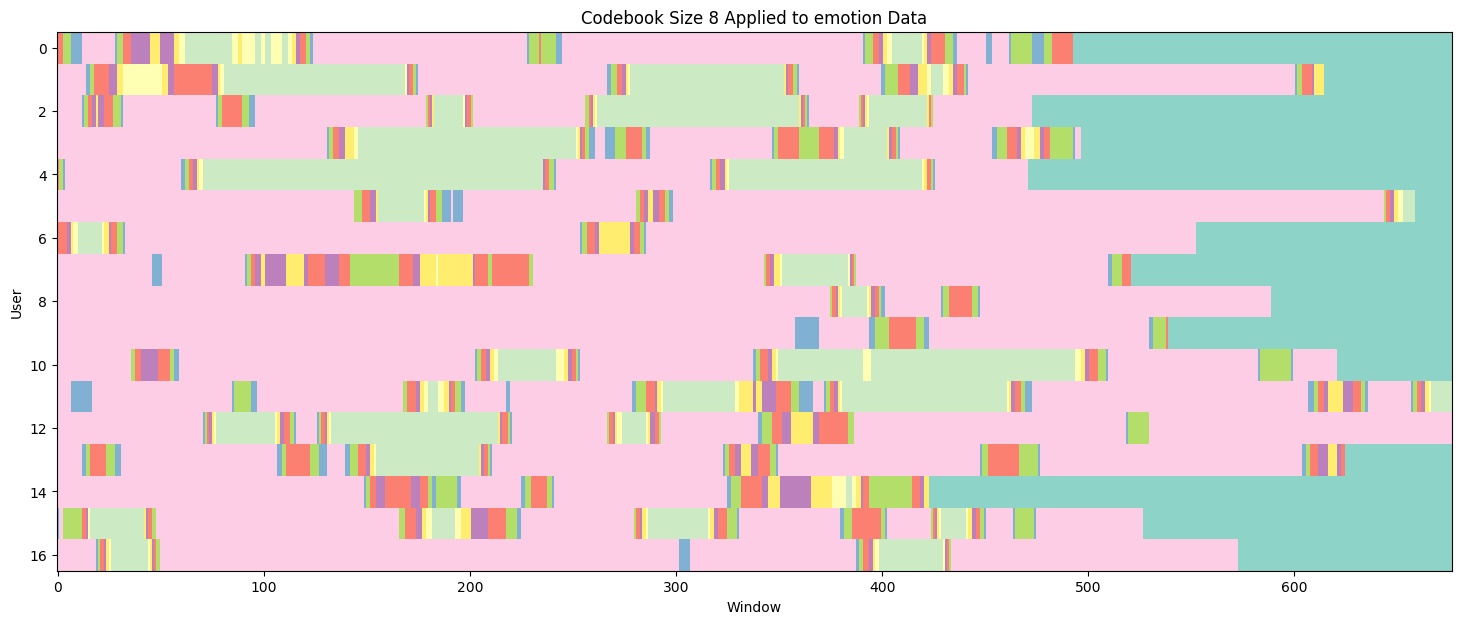

[111 112 113 211 212 214 411 412 413 414 512 613 614 711 713 811 813]


In [515]:
pl.rcParams['figure.figsize'] = [18, 7]
pl.imshow(results, cmap='Set3', interpolation='nearest', aspect='auto')
pl.title("Codebook Size %s Applied to %s Data"%(K, BOOK))
pl.ylabel("User")
pl.xlabel("Window")
pl.show()
print(USERS)

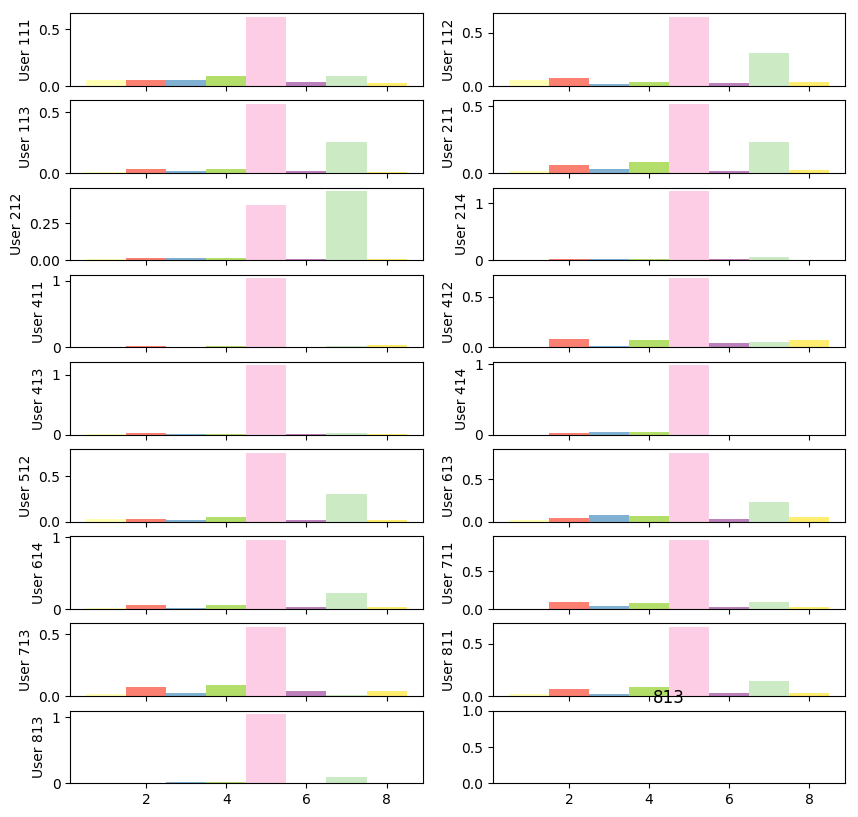

In [516]:
pl.rcParams['figure.figsize'] = [10, 10]
visualize_codebook_freq(u_freq)

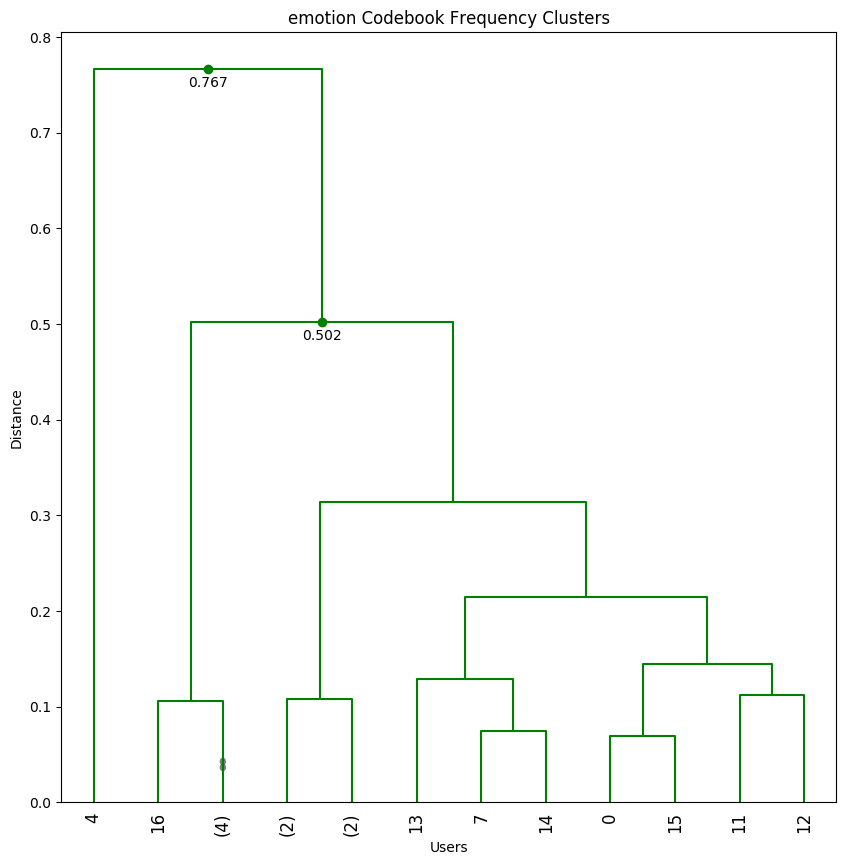

[2 2 2 2 3 1 1 2 1 1 2 2 2 2 2 2 1]
GROUP 1 [214 411 413 414 813] [0.004 0.022 0.015 0.017 0.888 0.009 0.034 0.01 ]
GROUP 2 [111 112 113 211 412 512 613 614 711 713 811] [0.02  0.07  0.025 0.062 0.587 0.036 0.169 0.031]


In [517]:
# good_session = [211,613,112,214,411,614,711,212,512,713]
# bad_session = []

u_freq_prop = []
for j, u in enumerate(u_freq):
    domain = u_freq[u][0]
    values = u_freq[u][1]
    f = np.zeros(K)
    for i in range(0, K):
        query = i+1
        idx = np.where(domain == query)
        if idx[0].shape[0] == 0:
            value = 0
        else: 
            f[i] = values[idx]
            
    start = BOUNDS[j]
    end = BOUNDS[j+1]
    n = end-start
    u_freq_prop.append(f/n)
    
    
codebook_frequencies = np.vstack(u_freq_prop)
CF = linkage(codebook_frequencies, method='complete', metric="euclidean")
fancy_dendrogram(
    CF,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above= 0.4,  # useful in small plots so annotations don't overlap
    max_d=max_d,
)

plt.title(BOOK + ' Codebook Frequency Clusters')
plt.xlabel('Users')
plt.ylabel('Distance')
        
plt.show()

clusters = fcluster(CF, 3, criterion='maxclust')
print(clusters)
g1 = np.where(clusters == 1)
g2 = np.where(clusters == 2)

cf1 = np.mean(codebook_frequencies[g1], 0)
cf2 = np.mean(codebook_frequencies[g2], 0)
print("GROUP 1", USERS[g1], cf1)
print("GROUP 2", USERS[g2], cf2)

diff = (cf2-cf1) * 100


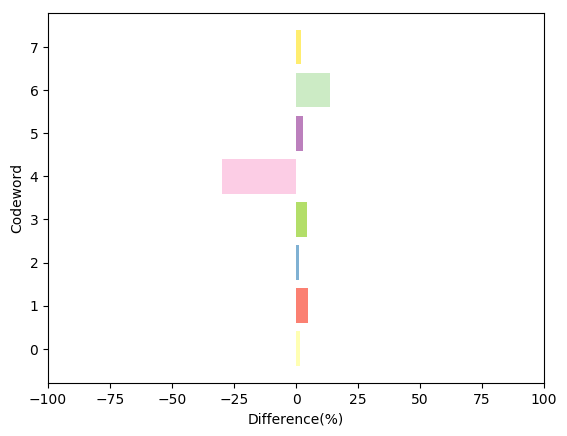

In [518]:
# Fixing random state for reproducibility
np.random.seed(19680801)

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
N = len(diff)
cm = plt.get_cmap("Set3")
colors = [cm(i) for i in np.linspace(0, 1, N+1)]

y_pos = np.arange(len(diff))
error = np.random.rand(len(people))
for i in range(N):
    ax.barh(y_pos[i], diff[i], color=colors[i+1])
# ax.set_yticks(y_pos)
# ax.set_yticklabels(people)
# ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Difference(%)')
ax.set_xlim(-100, 100)
ax.set_ylabel('Codeword')
# ax.set_title('How fast do you want to go today?')

plt.show()

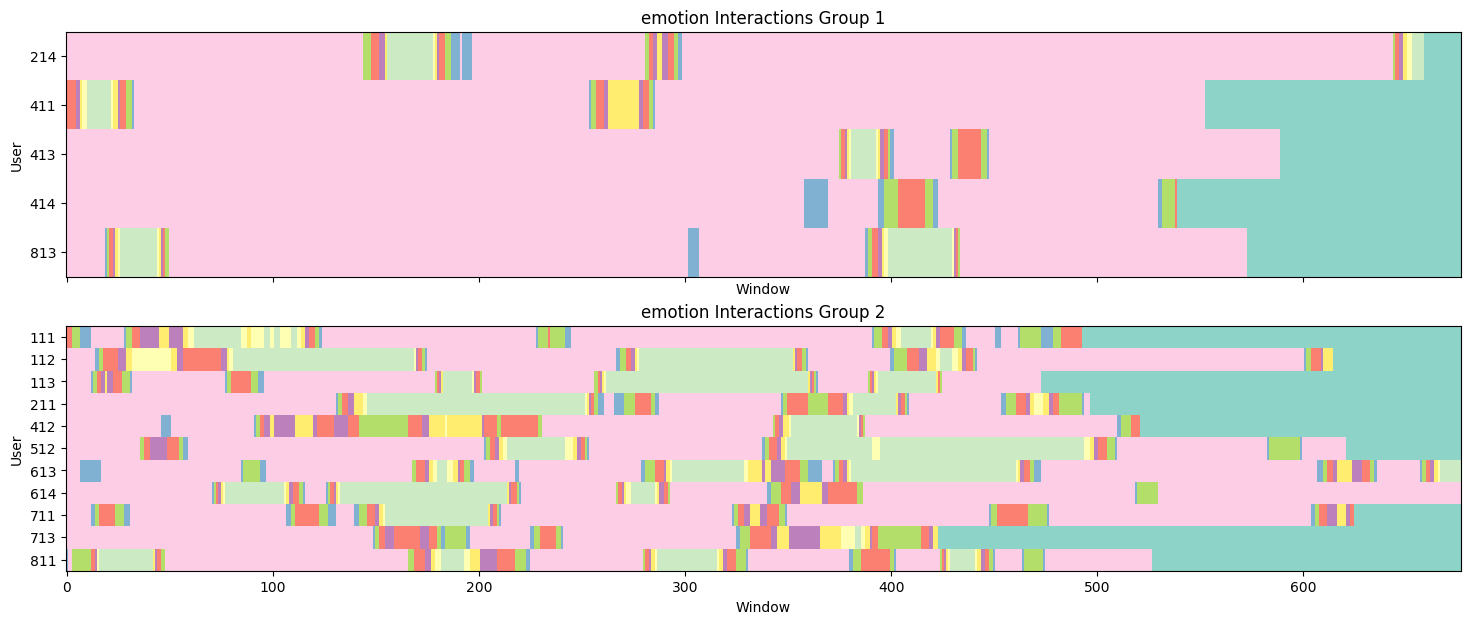

In [519]:
def plot_group(ax, group, title):
    ax.imshow(results[group], cmap='Set3', interpolation='nearest', aspect='auto')
    ax.set_title(title)
    ax.set_ylabel("User")
    ax.set_xlabel("Window")
    labels= USERS[group]
    T=np.arange(len(labels))
    ax.set_yticks(T)
    ax.set_yticklabels(labels)
    
pl.rcParams['figure.figsize'] = [18, 7]
fig, axs = pl.subplots(2, 1, sharex=True)   
plot_group(axs[0], g1, "%s Interactions Group 1"%(BOOK))
plot_group(axs[1], g2, "%s Interactions Group 2"%(BOOK))
pl.show()

In [523]:
# make_vtt(USERS[0], sparse_results[0])
for i, u in enumerate(USERS):
    make_vtt(u, sparse_results[i], BOOK)


File saved! irb/111/emotion_111.vtt
File saved! irb/112/emotion_112.vtt
File saved! irb/113/emotion_113.vtt
File saved! irb/211/emotion_211.vtt
File saved! irb/212/emotion_212.vtt
File saved! irb/214/emotion_214.vtt
File saved! irb/411/emotion_411.vtt
File saved! irb/412/emotion_412.vtt
File saved! irb/413/emotion_413.vtt
File saved! irb/414/emotion_414.vtt
File saved! irb/512/emotion_512.vtt
File saved! irb/613/emotion_613.vtt
File saved! irb/614/emotion_614.vtt
File saved! irb/711/emotion_711.vtt
File saved! irb/713/emotion_713.vtt
File saved! irb/811/emotion_811.vtt
File saved! irb/813/emotion_813.vtt


In [502]:
def visualize_codeword(ss, ax):
    N = WORD_SHAPE[0]
    ss = ss.reshape(WORD_SHAPE)
    cm = plt.get_cmap("Set3")
    colors = [cm(i) for i in np.linspace(0, 0.9, N)]
    for i in range(0, N):
        ax.plot(ss[i], color=colors[i])
        
def visualize_codebook(sss, subplot=False):
    if subplot: 
        
        fig, axs = pl.subplots(int(len(sss)/2), 2, sharex=True)        
        axs = axs.reshape(-1)
        for i, ss in enumerate(sss):
            axs[i].set_ylabel("Codeword %s"% i)
            visualize_codeword(ss, axs[i])
    else:
        for ss in sss:
            visualize_codeword(ss, pl)
    pl.show()


# Save for Qual Review

Need to run this in the codewords directory to have scrubbable video.
`npm install http-server -g
http-server -p 8000`


In [151]:
query = [
   (0, 100), 
   (200, 350)
]
q = json.dumps(query)
from IPython.core.display import display, HTML
display(HTML('<h1 id="data" data="%s">data</h1>'%q))

In [394]:
%%javascript
require.config({
  paths: {
      jquery: 'https://ajax.googleapis.com/ajax/libs/jquery/3.3.1/jquery.min.js',
      underscore: 'lib/underscore.js'
  }
});

<IPython.core.display.Javascript object>

In [395]:
%%HTML
<style>
    video{
        border: 2px solid #333;
    }
   
    #captions{
        width: 100%;
        text-align: center;
        font-size: 2em;
        padding: 1em;
    }
</style>

In [396]:
%%HTML
<div id="captions"></div>
<video width="100%" height="400" controls>
    <source src="http://localhost:8000/irb/111/data/screen_111_opt.mp4" type="video/mp4" controls>
    <track kind="subtitles" label="English subtitles" src="irb/111/acc.vtt" srclang="en" default></track>
</video>
<div id="transcript">
From retrospective think aloud
</div>

In [397]:
%%javascript
var textTrack = $('video')[0].textTracks[0]
textTrack.mode = "hidden"
for(var j = 0; j < textTrack.cues.length; ++j){
    var cue = textTrack.cues[j];
    if(! cue.data){
        cue.data = JSON.parse(cue.text);
        cue.text = cue.data.code;
    }
}

textTrack.oncuechange = function (){
    var myCues = this.activeCues;
    _.each(myCues, function(cue){
        $('#captions').html(cue.data.code).css('background', cue.data.color);
    })
}


var a;
a = JSON.parse($('#data').attr('data'))

$('.qual').remove()
_.each(a, function(item, i){
    var start = item[0]
    var end = item[1]
    var play_button = $('<button>').addClass("qual").html(i + " Segment").attr({
            start: start,
            end: end
    }).click(function(e){
            var s = parseFloat($(this).attr('start'))
            var e = parseFloat($(this).attr('end'))
            var vid = $('video')[0]
            console.log("Setting time to ", s)
            vid.currentTime = s
            vid.play()
    })
   $('video').parent().append(play_button)
   console.log()
});


<IPython.core.display.Javascript object>

# Notes

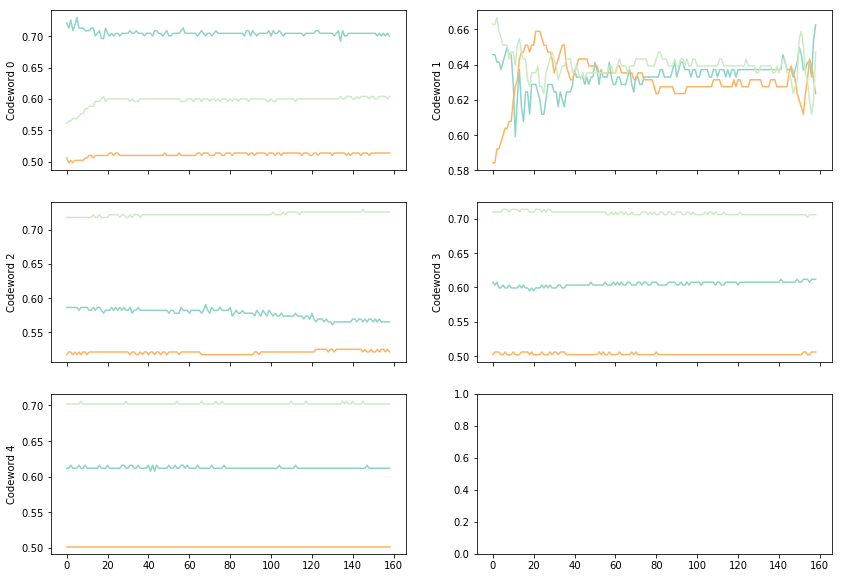

In [153]:
cb = np.array(list(codebook))
visualize_codebook(cb, subplot=True)

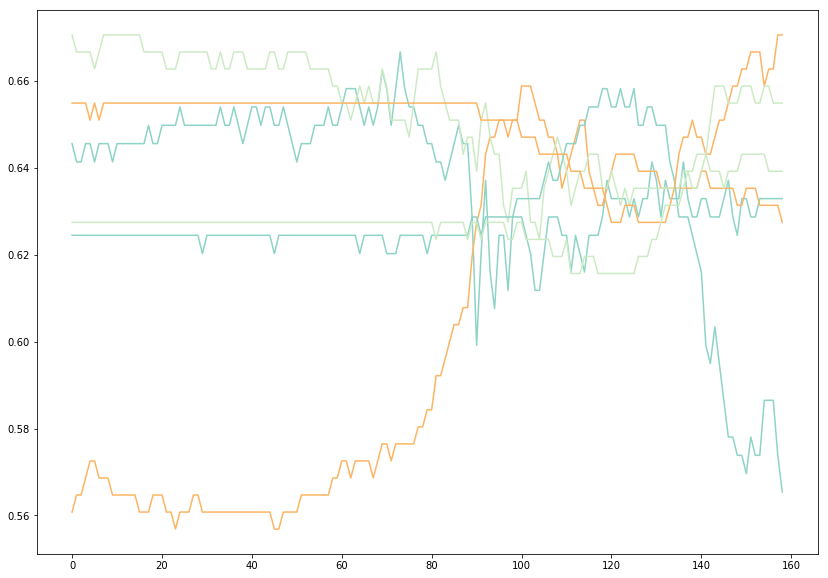

In [112]:
a = sss[0]
b = sss[10]
d2 = DTWDistance2D(a, b)
visualize_codebook([a, b], subplot=False)



In [113]:
def sample_kcenters(words, kcenters, cull_threshold=100):
#     print("WORDS", words.shape[0], "CENTERS", len(kcenters))
    
    if len(words) <= 1: 
        return np.array(kcenters)
    
    n = words.shape[0]
    dist = [dtw2(kcenters[-1], words[i]) for i in range(0, n)]
    dists = np.array(dist)
    
    idx = np.argsort(dists)
    kcenters.append(words[idx[-1]])    
    dists = np.sort(dists)
    cull_at = np.argmax(dists>cull_threshold)
    
    cull_indices = idx[:cull_at]
    cull_indices = np.append(cull_indices, idx[-1])
    words = np.delete(words, cull_indices, 0)
    
    return np.array(sample_kcenters(words, kcenters))